## Autotagging projects
* Who is the lead agency? 
    * Agency in this project = the entity who is receiving funding for this project.
* Is this project on or off the SHS or both?
* Create a sentence to summarize this.

In [1]:
import pandas as pd

# Settings
pd.options.display.max_columns = 100
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:,.2f}".format

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/project_prioritization/"
FILE = "fake_data.xlsx"

# My utilities
import _utils
from calitp import *

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
import re
from collections import Counter

import matplotlib.pyplot as plt  # plot package
import seaborn as sns  # statist graph package
import wordcloud  # will use for the word cloud plot
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import (  # optional to filter out the stopwords
    STOPWORDS,
    ImageColorGenerator,
    WordCloud,
)

### Preliminary Clean Up

In [3]:
# Read in file
df = to_snakecase(pd.read_excel(f"{GCS_FILE_PATH}{FILE}", sheet_name="fake"))

In [4]:
# Subset to columns I want.
df2 = df[
    [
        "project_name",
        "lead_agency",
        "project_description",
        "primary_mode",
        "secondary_mode_s",
        "shs_capacity_increase_detail",
    ]
]

#### Count Combos

In [5]:
# Count combos
combos = (
    df2.groupby(["primary_mode", "secondary_mode_s", "shs_capacity_increase_detail"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

In [6]:
# Find most commmon combos
combos.sort_values(["count"], ascending=False).head()

,primary_mode,secondary_mode_s,shs_capacity_increase_detail,count
171,Rail (Passenger),None,None,111
78,Highway,None,General Purpose Lane,62
10,Bike/Pedestrian,None,None,57
37,Grade Crossing,None,None,29
164,Rail (Freight),None,None,28


#### Count "None" Values for each column
* Around 2/3 of values are missing in secondary_mode & SHS. 

In [7]:
# How many none values are in the three columns
for i in [
    "primary_mode",
    "secondary_mode_s",
    "shs_capacity_increase_detail",
    "lead_agency",
    "project_description",
]:
    print((len((df2.loc[df2[i] == "None"])) / len(df2) * 100))

0.13458950201884254
66.21803499327052
62.0457604306864
31.090174966352624
6.191117092866756


### Are values in a column "highway related?"

In [8]:
def tagging_columns(
    df,
    tagging_col: str,
    new_col: str,
    keyword_list: list,
    true_keyword: str,
    false_keyword: str,
):
    """
    Search through a column for keywords.

    Args
    df: the dataframe.
    tagging_col (str): the column to search for the appearance of keywords.
    new_col (str): input whether or not the keyword was found.
    keyword_list (list): list of keywords to search through.
    true_keyword (str): replace "true" with a phrase that is more detailed.
    false_keyword (str): same as above, but with false.

    Returns: a dataframe with a new column stating whether
    the keyword(s) were found or not.
    """
    # Delinate items in keywords list using |.
    keywords = f"({'|'.join(keyword_list)})"

    # Lower the strings + strip excess white spaces.
    df[tagging_col] = df[tagging_col].str.lower().str.strip()

    # Create a new column that captures whether or not the keyword appears
    # Using str contains so interchange (new) and interchange (modifying) will appear.
    df["keyword_appears_bool"] = df[tagging_col].str.contains(keywords)

    # Function to categorize whether keyword was found.
    def keyword_found(row):
        if row["keyword_appears_bool"] == True:
            return true_keyword
        else:
            return false_keyword

    # Apply function and save results in a new column.
    df[new_col] = df.apply(lambda x: keyword_found(x), axis=1)

    # IF the original column wasn't populated and just says "none", replace the value in the
    # new column to accurately reflect this.
    df.loc[(df[tagging_col] == "none"), new_col] = "none"

    # Drop keyword col.
    df = df.drop(columns=["keyword_appears_bool"])

    return df

In [9]:
# Search through primary mode.
df3 = tagging_columns(
    df2,
    "primary_mode",
    "primary_mode_SHS",
    [
        "highway",
        "its",
        "interchange",
        "separation",
    ],
    "highway related",
    "not highway related",
)

/tmp/ipykernel_1562/4108280031.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1562/4108280031.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1562/4108280031.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1562/4108280031.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [10]:
# Preview that this is correct
df3[["primary_mode", "primary_mode_SHS"]].drop_duplicates()

,primary_mode,primary_mode_SHS
0,complete streets,not highway related
1,bike/pedestrian,not highway related
2,transit,not highway related
3,highway,highway related
5,its,highway related
10,interchange (new),highway related
12,bridge,not highway related
14,zev,not highway related
26,local roadway,not highway related
30,interchange (modification),highway related


In [11]:
# Search through secondary mode.
df3 = tagging_columns(
    df3,
    "secondary_mode_s",
    "secondary_mode_SHS",
    ["highway", "lane", "interchange", "its", "separation"],
    "highway related",
    "not highway related",
)

/tmp/ipykernel_1562/4108280031.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [12]:
df3[["secondary_mode_s", "secondary_mode_SHS"]].drop_duplicates()

,secondary_mode_s,secondary_mode_SHS
0,bike/pedestrian,not highway related
1,none,none
2,highway,highway related
4,bike/pedestrian\ncomplete streets,not highway related
5,its,highway related
7,zev,not highway related
12,bridge,not highway related
13,complete streets,not highway related
18,bike/pedestrian\nbridge,not highway related
19,bike/pedestrian\ncomplete streets\nits\ntransit,highway related


In [13]:
# Search through SHS Capacity Detail.
df3 = tagging_columns(
    df3,
    "shs_capacity_increase_detail",
    "shs_capacity_increase_detail_SHS",
    ["highway", "lane", "interchange"],
    "highway related",
    "not highway related",
)

/tmp/ipykernel_1562/4108280031.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [14]:
df3[
    [
        "shs_capacity_increase_detail",
        "shs_capacity_increase_detail_SHS",
    ]
].drop_duplicates()

,shs_capacity_increase_detail,shs_capacity_increase_detail_SHS
0,none,none
3,auxiliary lane,highway related
6,general purpose lane,highway related
8,transit/bus-only lane (addition),highway related
10,interchange (new),highway related
27,managed lane,highway related
44,managed lane (conversion),highway related
45,express lane (conversion),highway related
51,auxiliary lane\nmanaged lane (addition),highway related
52,managed lanes addition,highway related


### Tagging None Values
* As seen above, Secondary Mode & SHS Detail are missing 2/3 of their values. 
* Primary mode is almost complete filled out.
* Evaluate how "complete" each project/row is for these 3 columns 
* 45% of rows have one none value, 41% have 2...

In [15]:
# https://stackoverflow.com/questions/60446836/highlight-text-string-type-in-pandas-df-matching-text
# https://stackoverflow.com/questions/73839250/count-number-of-occurrences-of-text-over-row-python-pandas
# Count number of times "none" appears.
df3["none_count"] = df3[
    ["shs_capacity_increase_detail_SHS", "secondary_mode_SHS", "primary_mode_SHS"]
].apply(
    lambda x: sum([i.lower().count("none") for i in x if isinstance(i, str)]), axis=1
)

In [16]:
(df3.none_count.value_counts() / len(df3)) * 100

1   45.36
2   41.32
0   13.19
3    0.13
Name: none_count, dtype: float64

### 1st Round of Tagging
* Determine who is the lead agency.
* Using the three categorical cols, try to tag whether this project is on/off the SHS. 
    

In [17]:
# Tag if the lead agency is Caltrans or a partner or unknown.
def CT_or_partner(row):
    # If partner is none, return Unknown.
    if row.lead_agency == "None":
        return "unknown"
        # If only Caltrans, return Caltrans
    if row.lead_agency == "Caltrans":
        return "Caltrans"
        # Everything else is a partner agency
    else:
        return "a partner"

In [18]:
# Apply the function
df3["caltrans_or_partner"] = df3.apply(CT_or_partner, axis=1)

In [19]:
"""
  # If secondary, primary, and SHS are all highway related: on the SHS. Or perhaps possibly?
        elif (
            (row.secondary_mode_SHS == "highway related")
            and (row.primary_mode_SHS == "highway related")
            and (row.shs_capacity_increase_detail_SHS == "highway related")
        ):
            return "on the SHS"

        # If  primary and SHS are all highway related: on the SHS. 
        elif (row.primary_mode_SHS == "highway related") and (
            row.shs_capacity_increase_detail_SHS == "highway related"
        ):
            return "on the SHS"
"""

'\n  # If secondary, primary, and SHS are all highway related: on the SHS. Or perhaps possibly?\n        elif (\n            (row.secondary_mode_SHS == "highway related")\n            and (row.primary_mode_SHS == "highway related")\n            and (row.shs_capacity_increase_detail_SHS == "highway related")\n        ):\n            return "on the SHS"\n\n        # If  primary and SHS are all highway related: on the SHS. \n        elif (row.primary_mode_SHS == "highway related") and (\n            row.shs_capacity_increase_detail_SHS == "highway related"\n        ):\n            return "on the SHS"\n'

In [20]:
def tagging_primary_secondary_SHS(df):

    """
    After applying the tagging_columns() to the three categorical columns (SHS Capacity Increase Detail,
    Secondary Mode SHS, and Primary Mode SHS), use the new true/false columsn
    to determine whether or not projects are on/off the SHS. If there are too many 'none' values,
    skip over tagging to combing through project descriptions.

    Args
    df: the dataframe.

    Returns: a dataframe tagging projects.
    """
    # Count number of times "none" appears for the three categorical columns by each project/row.
    # https://stackoverflow.com/questions/73839250/count-number-of-occurrences-of-text-over-row-python-pandas
    df["none_count"] = df[
        ["shs_capacity_increase_detail_SHS", "secondary_mode_SHS", "primary_mode_SHS"]
    ].apply(
        lambda x: sum([i.lower().count("none") for i in x if isinstance(i, str)]),
        axis=1,
    )

    # Begin tagging based on the three columns
    def on_SHS(row):
        # As primary mode is nearly 100% filled out and if there's only 0-1 missing values: not on the SHS. 
        if (row.primary_mode_SHS == "not highway related") and (row.none_count < 2):
            return "not on the SHS"
        
         # As primary mode is nearly 100% filled out and if there's only 0-1 missing values: on the SHS. 
        elif (row.primary_mode_SHS == "highway related") and (row.none_count < 2):
            return "on the SHS"

        # If a project has 2+ none, just skip over tagging based on the aforementioned columns.
        elif row.none_count > 1:
            return "not enough information"
        
        # If primary mode is not highway related & two columns are not highway related: not on SHS.
        elif (
            (row.primary_mode_SHS == "not highway related")
            and (row.secondary_mode_SHS == "not highway related")
            and (row.shs_capacity_increase_detail_SHS == "not highway related")
        ):
            return "not on the SHS"
        else:
            return "possibly on the SHS"

    # Apply the function
    df["on_off_shs_category_tags"] = df.apply(on_SHS, axis=1)

    return df

In [21]:
df4 = tagging_primary_secondary_SHS(df3)

In [22]:
""" ORIGINAL VERSION
def tagging_primary_secondary_SHS(df):
    # Tag if a project is on the SHS or not thorugh various combos.
    def on_SHS(row):
        # If both secondary, primary, and SHS are highway related and lead agency is Caltrans: on SHS
        if (
            (row.secondary_mode_SHS == "highway related")
            and (row.primary_mode_SHS == "highway related")
            and (row.shs_capacity_increase_detail_SHS == "highway related")
            and (row.caltrans_or_partner == "Caltrans")
        ):
            return "on the SHS"
        # If secondary, primary, and SHS are all highway related: on the SHS. Or perhaps possibly?
        elif (
            (row.secondary_mode_SHS == "highway related")
            and (row.primary_mode_SHS == "highway related")
            and (row.shs_capacity_increase_detail_SHS == "highway related")
        ):
            return "on the SHS"
        # If primary mode is not highway related & two columns have no info: not on SHS.
        elif (
            (row.primary_mode_SHS == "not highway related")
            and (row.secondary_mode_SHS == "none")
            and (row.shs_capacity_increase_detail_SHS == "none")
        ):
            return "not on the SHS"
        # If primary mode is not highway related & two columns are not highway related: not on SHS.
        elif (
            (row.primary_mode_SHS == "not highway related")
            and (row.secondary_mode_SHS == "not highway related")
            and (row.shs_capacity_increase_detail_SHS == "not highway related")
        ):
            return "not on the SHS"
        # Everything else is not on SHS.
        else:
            return "possibly on the SHS"

    # Apply the function
    df["on_off_shs_category_tags"] = df.apply(on_SHS, axis=1)

    return df
    """

' ORIGINAL VERSION\ndef tagging_primary_secondary_SHS(df):\n    # Tag if a project is on the SHS or not thorugh various combos.\n    def on_SHS(row):\n        # If both secondary, primary, and SHS are highway related and lead agency is Caltrans: on SHS\n        if (\n            (row.secondary_mode_SHS == "highway related")\n            and (row.primary_mode_SHS == "highway related")\n            and (row.shs_capacity_increase_detail_SHS == "highway related")\n            and (row.caltrans_or_partner == "Caltrans")\n        ):\n            return "on the SHS"\n        # If secondary, primary, and SHS are all highway related: on the SHS. Or perhaps possibly?\n        elif (\n            (row.secondary_mode_SHS == "highway related")\n            and (row.primary_mode_SHS == "highway related")\n            and (row.shs_capacity_increase_detail_SHS == "highway related")\n        ):\n            return "on the SHS"\n        # If primary mode is not highway related & two columns have no info

In [23]:
# Check value counts.
(df4.caltrans_or_partner.value_counts() / len(df4)) * 100

a partner   47.11
unknown     31.09
Caltrans    21.80
Name: caltrans_or_partner, dtype: float64

In [24]:
# Check value counts.
df4.on_off_shs_category_tags.value_counts()

not enough information    308
on the SHS                298
not on the SHS            137
Name: on_off_shs_category_tags, dtype: int64

In [25]:
# Check value counts.
df4.on_off_shs_category_tags.value_counts() / len(df4) * 100

not enough information   41.45
on the SHS               40.11
not on the SHS           18.44
Name: on_off_shs_category_tags, dtype: float64

In [26]:
combos5 = (
    df4.groupby(
        [
            "on_off_shs_category_tags",
            "shs_capacity_increase_detail_SHS",
            "primary_mode_SHS",
            "secondary_mode_SHS",
        ]
    )
    .agg({"project_description": "count"})
    .reset_index()
    .rename(columns={"project_description": "total projects"})
    .sort_values("total projects", ascending=False)
    .reset_index(drop=True)
)

In [27]:
# Check out results 
combos5

,on_off_shs_category_tags,shs_capacity_increase_detail_SHS,primary_mode_SHS,secondary_mode_SHS,total projects
0,not enough information,none,not highway related,none,258
1,on the SHS,highway related,highway related,none,178
2,not on the SHS,none,not highway related,not highway related,98
3,on the SHS,highway related,highway related,highway related,59
4,not enough information,none,highway related,none,49
5,on the SHS,highway related,highway related,not highway related,28
6,not on the SHS,none,not highway related,highway related,25
7,on the SHS,none,highway related,not highway related,24
8,on the SHS,none,highway related,highway related,6
9,not on the SHS,highway related,not highway related,none,5


In [28]:
# https://stackoverflow.com/questions/60446836/highlight-text-string-type-in-pandas-df-matching-text
# https://stackoverflow.com/questions/73839250/count-number-of-occurrences-of-text-over-row-python-pandas
# Count number of times "none" appears.
combos5["none_count"] = combos5.apply(
    lambda x: sum([i.lower().count("none") for i in x if isinstance(i, str)]), axis=1
)

In [29]:
# How many times does "none" appear for each combo?
combos5.none_count.value_counts()

1    7
0    6
2    2
3    1
Name: none_count, dtype: int64

In [30]:
combos5.style.where(lambda val: "none" in str(val), "color: red")

/tmp/ipykernel_1562/2958249600.py:1: FutureWarning: this method is deprecated in favour of `Styler.applymap()`


,on_off_shs_category_tags,shs_capacity_increase_detail_SHS,primary_mode_SHS,secondary_mode_SHS,total projects,none_count
0,not enough information,none,not highway related,none,258,2
1,on the SHS,highway related,highway related,none,178,1
2,not on the SHS,none,not highway related,not highway related,98,1
3,on the SHS,highway related,highway related,highway related,59,0
4,not enough information,none,highway related,none,49,2
5,on the SHS,highway related,highway related,not highway related,28,0
6,not on the SHS,none,not highway related,highway related,25,1
7,on the SHS,none,highway related,not highway related,24,1
8,on the SHS,none,highway related,highway related,6,1
9,not on the SHS,highway related,not highway related,none,5,1


### Investigation:
* Around 42 percent have not enough info. Around 35 percent of values are "possibly on the SHS." 31 percent of projects are led by an unknown agency. Look through at these projects closer.
* Discern potential patterns in the three columns for these projects.


In [31]:
# Filter for unknown lead agencies & possibly on SHS.
"""
df5 = df4[
    (
        (df4.caltrans_or_partner == "unknown")
        | (
            df4.on_off_shs_category_tags.isin(["possibly on the SHS"])
            | (df4.on_off_shs_category_tags.isin(["not enough information"]))
        )
    )
]
"""

'\ndf5 = df4[\n    (\n        (df4.caltrans_or_partner == "unknown")\n        | (\n            df4.on_off_shs_category_tags.isin(["possibly on the SHS"])\n            | (df4.on_off_shs_category_tags.isin(["not enough information"]))\n        )\n    )\n]\n'

In [32]:
# f"{len(df5)} total projects to double check out of {len(df4)}."

In [33]:
# df5.caltrans_or_partner.value_counts()

#### Most Common Words: Word Cloud
* https://www.kaggle.com/code/olgaberezovsky/word-cloud-using-python-pandas/notebook

In [34]:
extra_stop_words = [
    "project",
    "new",
    "improvement",
    "improve",
    "construct",
    "along",
    "improvements",
    "include",
    "will",
    "caltrans",
    "exist",
    "los angeles",
    "san diego",
    "near",
    "area",
    "south",
    "north" "street",
]

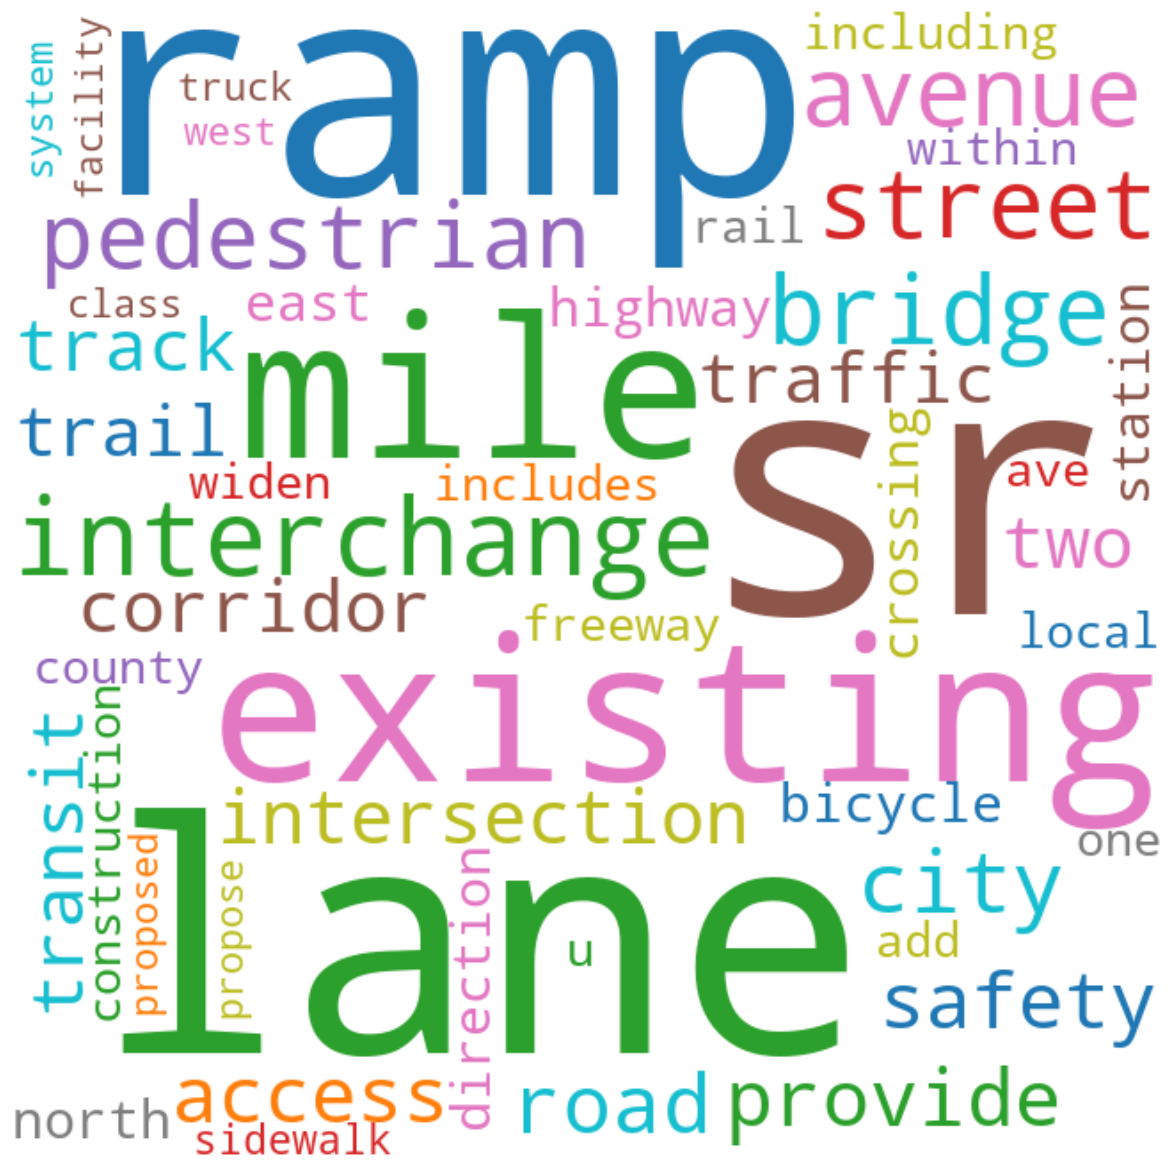

In [35]:
# Make a wordcloud of the top 100 words without certain stop words
_utils.wordcloud(df4, "project_description", 100, extra_stop_words)

#### Most Common Phrases
* Look through common phrases, in addition to single words. 

In [36]:
# Look for 2 word phrases through project desc
phrases = _utils.get_list_of_words(df4, "project_description", extra_stop_words)

In [37]:
df_phrases = _utils.common_phrases(df4, phrases, 2)

In [38]:
# df_phrases.head(40)

### Search through for SHS related words in project description 

In [39]:
# Keywords related to SHS - based on word cloud/common phrases results
SHS_keywords_list = [
    "sr",
    "state highway",
    "sr-",
    "state route",
    "sr ",
    "highway 1",
    "interstate",
    "us 101",
    "route 99",
    "i-",
    "us-",
    "101",
]

In [40]:
# Search through project description for keywords above
df5 = tagging_columns(
    df4,
    "project_description",
    "contains_SR_reference",
    SHS_keywords_list,
    "contains SHS keyword(s)",
    "does not contain SHS keyword(s)",
)

/tmp/ipykernel_1562/4108280031.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [41]:
df5.contains_SR_reference.value_counts()

does not contain SHS keyword(s)    381
contains SHS keyword(s)            316
none                                46
Name: contains_SR_reference, dtype: int64

In [42]:
# 46 projects have missing descriptions.
len(
    df5[["project_name", "project_description", "contains_SR_reference"]].loc[
        df5["contains_SR_reference"] == "none"
    ]
)

46

In [43]:
# TURN THIS INTO A FUNC LATER.
# Extract keywords from project description that are in the list into a new col
# https://stackoverflow.com/questions/67746078/how-to-highlight-and-count-specific-keywords-in-a-pandas-dataframe
df5["SHS_keyword_match"] = df5["project_description"].str.findall(
    rf"\b(?:{'|'.join(SHS_keywords_list)})\b"
)

#### Investigate: projects that contain SHS keywords vs. those that don't.

In [44]:
# Subset for a smaller df
subset_cols = [
    "project_name",
    "lead_agency",
    "project_description",
    "SHS_keyword_match",
    "on_off_shs_category_tags",
    "contains_SR_reference",
    "SHS_keyword_match",
]

In [45]:
# Subset for projects with SHS keywords
SHS_keywords_df = (
    df5[subset_cols].loc[df5["contains_SR_reference"] == "contains SHS keyword(s)"]
).reset_index(drop=True)

In [46]:
# SHS_keywords_df.sample(5)

In [67]:
# Filter for values in SHS Keyword Match that are actually empty
# Replace this with "does not contain SHS Keywords"
# (SHS_keywords_df[SHS_keywords_df["SHS_keyword_match"].str.len() == 0])
# df.loc[(df["name"] == "Butte County Association of Governments"), "ntd_id"] = "90208"
# SHS_keywords_df.loc[ (SHS_keywords_df["SHS_keyword_match"].str.len() == 0), "contains_SR_reference"] = "does not contain SHS keyword(s)"

In [48]:
# Double check that func above works
# SHS_keywords_df.loc[SHS_keywords_df['project_name'] == "Pioneer Blvd Grade Separation"]

In [49]:
# Subset for projects without SHS keywords
no_SHS_keywords_df = (
    df5[subset_cols].loc[
        df5["contains_SR_reference"] == "does not contain SHS keyword(s)"
    ]
).reset_index(drop=True)

In [65]:
# Investigate why some "on the SHS" don't contain any SHS keywords in it's description...
# no_SHS_keywords_df.loc[no_SHS_keywords_df['On_SHS'] == 'on the SHS']

### Retag using project descriptions

In [51]:
def SHS_project_description_tag(df):
    
    # Tag if a project's desc has a SHS keyword/SHS keywords or not
    def keywords(row):
        
        # If columns have 0-1 missing values and does not contain SHS keywords: not on the SHS
        if ((row.on_off_shs_category_tags == "not on the SHS")|(row.on_off_shs_category_tags == "on the SHS")) and (row.none_count < 2) and (row.contains_SR_reference == "does not contain SHS keyword(s)"): 
            return "not on the SHS"
        
        # If columns have 0-1 missing values, determined above as not SHS, and does contain SHS keywords: on the SHS
        elif (row.on_off_shs_category_tags == "on the SHS") and (row.none_count < 2) and (row.contains_SR_reference == "contains SHS keyword(s)"): 
            return "on the SHS"
        
        # If no SHS keywords found and SHS tag is either not on SHS/not enough info: not on SHS.
        elif (row.on_off_shs_category_tags == "not enough information") and ((row.contains_SR_reference == "does not contain SHS keyword(s)") | (row.contains_SR_reference == "none")):
            return "not on the SHS"

        # If SHS keywords found and SHS tag is either on the SHS or not enough info: on the SHS
        elif (
            row.on_off_shs_category_tags == "not enough information"
        ) | (row.on_off_shs_category_tags == "possibly on the SHS") and (
            row.contains_SR_reference == "contains SHS keyword(s)"
        ):
            return "on the SHS"

        # Everything else is not on SHS.
        else:
            return "possibly on the SHS"

    # Apply the function
    df["on_shs_project_desc_tag"] = df.apply(keywords, axis=1)

    # Create a summary sentence
    df["sentence"] = (
        "The lead agency is "
        + df["caltrans_or_partner"]
        + " and the project is "
        + df["on_shs_project_desc_tag"]
        + "."
    )

    return df

#### Compare first attempt of the sentence versus second attempt.

In [52]:
df6 = SHS_project_description_tag(df5)

In [53]:
# First round of tagging
df5.on_off_shs_category_tags.value_counts()

not enough information    308
on the SHS                298
not on the SHS            137
Name: on_off_shs_category_tags, dtype: int64

In [54]:
# Second round of tagging
df6.on_shs_project_desc_tag.value_counts()

not on the SHS         412
on the SHS             267
possibly on the SHS     64
Name: on_shs_project_desc_tag, dtype: int64

In [55]:
# Goal to get rid of possibly on the SHS category?
(df6.on_shs_project_desc_tag.value_counts() / len(df6)) * 100

not on the SHS        55.45
on the SHS            35.94
possibly on the SHS    8.61
Name: on_shs_project_desc_tag, dtype: float64

In [56]:
# Subset
subset = [
        "project_description",
          "SHS_keyword_match",
        "primary_mode",
        "shs_capacity_increase_detail",
        "secondary_mode_s",
        "contains_SR_reference",
        "on_off_shs_category_tags",
        "on_shs_project_desc_tag",
  
    ]

In [57]:
df6[subset].loc[df6["on_shs_project_desc_tag"] == "possibly on the SHS"].sample(3)

,project_description,SHS_keyword_match,primary_mode,shs_capacity_increase_detail,secondary_mode_s,contains_SR_reference,on_off_shs_category_tags,on_shs_project_desc_tag
6,"us 101 couplet for safety, livability, and sustainability. add three lanes of travel for vehicle operations with two lanes southbound using koster street and one additional lane northbound for one alternative. traffic calming features include adding class ii bike lanes, widen sidewalks, add parking, and other complete streets features.",[us 101],complete streets,general purpose lane,none,contains SHS keyword(s),not on the SHS,possibly on the SHS
201,"integrated power generation and storage system at an 1100 employee ag facility. 5-megawatt solar, natural gas, and battery installation at taseteful selections' specialty potato plant. use advanced computer systems in increase efficiency and operate during external disruptions to its power.",[],zev,none,zev,contains SHS keyword(s),not on the SHS,possibly on the SHS
186,"the project location is the coalinga-avenal safety roadside rest area (srra), which has both northbound and southbound access from interstate 5 (i-5). the srra currently covers an area of approximately 38 acres and includes restrooms, water, picnic tables, litter, phone, ada accessibility, food vending, and a pet area as amenities. the srra is north of the interchange of i-5 and state route (sr) 269. sr 269 is also known as lassen avenue north of the interchange and as skyline boulevard south of the interchange; in the nearby city of avenal, california, sr 269 functions as a main street. in the california statewide truck parking study (cstps) currently in development, the coalinga-avenal srra is identified in a profile within appendix b as one of the srras operating at or over capacity, exacerbating illegal truck parking and driver safety concerns. in an effort to address this issue, the intent of this proposal is to acquire the necessary right of way to expand truck parking at the coalinga-avenal srra to meet the projected demand of 37 new truck/bus stalls and 110 new car stalls, while also introducing 6 new ev charging stations per the recommendations of the cstps and other studies, and engaging with the community in avenal to gather input on incorporating features to the srra to encourage tourism.","[interstate, i-, i-, state route, sr, sr, sr]",truck parking,none,highway,contains SHS keyword(s),not on the SHS,possibly on the SHS


In [58]:
combos6 = (
    df6.groupby(
        ["on_off_shs_category_tags", "on_shs_project_desc_tag", "contains_SR_reference"]
    )
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

In [59]:
combos6["did_both_tagging_functions_give_same_result"] = (
    combos6["on_shs_project_desc_tag"] == combos6["on_off_shs_category_tags"]
)

In [60]:
combos6["did_both_tagging_functions_give_same_result"].value_counts()

False    7
True     2
Name: did_both_tagging_functions_give_same_result, dtype: int64

In [61]:
# If it's tagged as "on the SHS" first round but now "possibly" b/c doesn't contain SHS keyword,
# which one is correct...
combos6.sort_values("count", ascending=False)

,on_off_shs_category_tags,on_shs_project_desc_tag,contains_SR_reference,count,did_both_tagging_functions_give_same_result
0,not enough information,not on the SHS,does not contain SHS keyword(s),208,False
7,on the SHS,on the SHS,contains SHS keyword(s),198,True
6,on the SHS,not on the SHS,does not contain SHS keyword(s),96,False
3,not on the SHS,not on the SHS,does not contain SHS keyword(s),77,True
2,not enough information,on the SHS,contains SHS keyword(s),69,False
4,not on the SHS,possibly on the SHS,contains SHS keyword(s),49,False
1,not enough information,not on the SHS,none,31,False
5,not on the SHS,possibly on the SHS,none,11,False
8,on the SHS,possibly on the SHS,none,4,False


#### Check out some combos. 
* Projects that were tagged as "not on the SHS" at first  but "contains SHS keywords"
* Projects that were tagged as "on the SHS" but "does not conatin SHS keywords"

In [62]:
(df6[subset][
    ((df6.on_off_shs_category_tags == "not on the SHS") & (df6.contains_SR_reference == "contains SHS keyword(s)" ))
]).sample(2)

,project_description,SHS_keyword_match,primary_mode,shs_capacity_increase_detail,secondary_mode_s,contains_SR_reference,on_off_shs_category_tags,on_shs_project_desc_tag
687,"accelerated freight bridges project:\ninvestigation of six bridges along i-10 and sr 60 within sbd and riv counties for needs to strengthen/replace bridges or rehab decks.\nupon inspection, ramona ave oc (bridge #54-0745) at sbd-60-pm r1.37 will need to be addressed.\nthis project is part of a larger project that includes d7's accelerated freight bridges at various locations along sr-60 within la county","[i-, sr, sr]",bridge,none,rail (freight),contains SHS keyword(s),not on the SHS,possibly on the SHS
497,"construct two-way class iv bikeway on nb side of sr 39. at the intersection of sr 39/sr 90, stripe class ii bike lanes adjacent to the crosswalks. upgrade crosswalks to continental crosswalks. install bicycle signal phasing at fashion lane and at lambert road. near disadvantaged community: census tract: 6059001201","[sr, sr, sr]",bike/pedestrian,none,bike/pedestrian,contains SHS keyword(s),not on the SHS,possibly on the SHS


In [63]:
(df6[subset][
    ((df6.on_off_shs_category_tags == "on the SHS") & (df6.contains_SR_reference == "does not contain SHS keyword(s)" ))
]).sample(2)

,project_description,SHS_keyword_match,primary_mode,shs_capacity_increase_detail,secondary_mode_s,contains_SR_reference,on_off_shs_category_tags,on_shs_project_desc_tag
11,add class i and class iv bike facilities to broadway in eureka,[],highway,none,bike/pedestrian\ncomplete streets,does not contain SHS keyword(s),on the SHS,not on the SHS
289,"convert existing hov lanes to hot lanes the is a split project from ea35430. the project proposes three alternatives: alt. 1 -no-build, alt. 2 - convert existing high occupancy vehicle (hov) to a high occupancy toll (hot) in each direction for approximately 34.8 lane miles, and alt. 3 - provide an additional managed lane, resulting in two hov or hot lanes in each direction, for approximately 69.6 lane miles.\n\n\n(lacmta tier 1) metro has awarded paed contract to their consultant to start in july 2021, waiting for cooperative agreement execution for caltrans staff to engage with metro/consultant.",[],highway,express lane,none,does not contain SHS keyword(s),on the SHS,not on the SHS
